# 21 - Latent Dirichlet Allocation - Ejemplo Topics & Terms en Tweets Políticos


* En este Notebook vamos a agrupar los tweets publicados por los partidos políticos y los políticos para ver si verdaderamente el LDA es capaz de diferenciar las 4 tendencias políticas (4 Topics) que hay en estos tweets.


* Por otro lado tambien es interesante ver cuales son las palabras (Terms) característicos de cada uno de estos Topics.


* Para ello vamos a realizar los siguientes pasos:

    1. Carga de datos
    2. Normalizar los tweets (igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*)
    3. Creacción del diccionario y la bolsa de palabras
    4. Selección del número óptimo de Topics
    5. Creacción del Modelo
    6. Visualización

<hr>


## Carga de Datos


* El fichero que contiene los tweets lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y mostramos una muestra:

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

tweets_file = './data/tweets_politica.csv'
df = pd.read_csv(tweets_file, sep='::::', engine='python')
tweets = [tuple(x) for x in df[['tweet', 'partido']].values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))
df.sample(5)

Número de Tweets Cargados: 3843


,cuenta,partido,timestamp,tweet
575,sanchezcastejon,psoe,1556052141,Si las derechas y la ultraderecha suman harán ...
1671,sanchezcastejon,psoe,1557816517,La Europa de todos y todas. La de las mujeres....
697,Albert_Rivera,ciudadanos,1556263408,Hoy cerramos la campaña de la ilusión en #Vale...
2462,ahorapodemos,podemos,1558248613,"📽 ""Queremos ciudades que tengan soberanía sobr..."
2688,populares,pp,1558608549,🔴 EN DIRECTO@pablocasado_ interviene en un act...


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un ejemplo didáctica se ha realizado una normalización '*sencilla*'.

In [2]:
import numpy as np
import spacy
nlp = spacy.load('es_core_news_sm')

X = [doc[0] for doc in tweets]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        sentense = nlp(sentense.lower().replace('.', ' ').replace('#', ' '))
        # Puntos 4,5,6,7 y 8
        sentenses[index] = ([word.lemma_ for word in sentense if (not word.is_punct)
                             and (len(word.text) > 2) and (not word.is_stop)
                             and (not word.text.startswith('@'))
                             and (not word.text.startswith('http'))
                             and (not ':' in word.text)])
    return sentenses

# Normalizamos las frases
X_norm = normalize(X)

<hr>


## Creamos el Diccionario y la Matriz (Bolsa de Palabras)

In [3]:
from pprint import pprint
from gensim import corpora
from collections import defaultdict

# Creamos el diccionario (vocabulario)
frequency = defaultdict(int)
for doc in X_norm:
    for token in doc:
        frequency[token] += 1
        
documents = [[token for token in doc] for doc in X_norm]
dictionary = corpora.Dictionary(documents)
print('Diccionario:\n{}'.format(dictionary))


# Creamos la Bolsa de Palabras
corpus = [dictionary.doc2bow(doc) for doc in documents]
print('\nPrimer Documento del Corpus:\n{}'.format(corpus[0]))

Diccionario:
Dictionary(10564 unique tokens: ['libertaddeprensa', 'libertar', 'p44ycodyfo', 'partir', 'popular']...)

Primer Documento del Corpus:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


<hr>


## Selección del número óptimo de Topics


* Veamos la coherencia para modelos desde 2 a 10 temas (Topics).

In [4]:
warnings.filterwarnings('ignore')
from gensim.models import LdaModel, CoherenceModel

coherence = []
min_topics = 2
max_topics = 11
for num_topics in range(min_topics, max_topics, 1):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=168,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    coherencemodel = CoherenceModel(model=lda_model, texts=X_norm, dictionary=dictionary, coherence='c_uci')
    coherence.append(coherencemodel.get_coherence())
    
index = ["Num Topics: {num}".format(num=num) for num in range(min_topics, max_topics, 1)]
pd.DataFrame(coherence, index=index, columns=['Coherence'])

,Coherence
Num Topics: 2,-1.595029
Num Topics: 3,-2.106844
Num Topics: 4,-2.221796
Num Topics: 5,-3.892725
Num Topics: 6,-3.115776
Num Topics: 7,-5.367448
Num Topics: 8,-5.883955
Num Topics: 9,-6.470811
Num Topics: 10,-5.686272


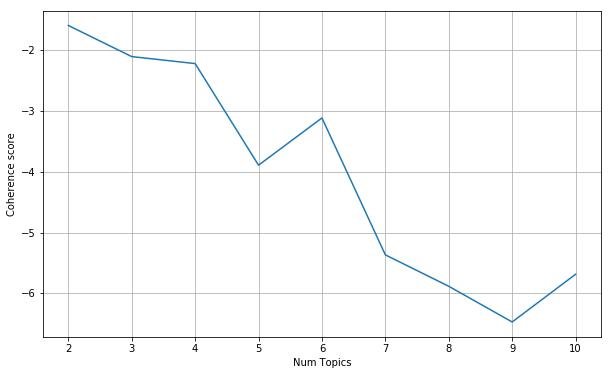

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(range(min_topics, max_topics, 1), coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.grid()
plt.show()

<hr>


## Creamos el Modelo:


* Con la coherencia obtenida, podemos observar que con ***4 Topics*** tenemos un valor de coherencia bastante similar al obtenido con 2 y 3 Topics, lo que hace pensar que si que hay diferencias entre las 4 tendencias políticas.


* Vamos a crear el modelo con 4 Topics:

In [6]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, random_state=168)


<hr>


## Visualización 4 Topics:

In [7]:
import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)